
* 2 балла 	Построен валидационный датасет. 

* 2 балла	Построен S-learner. Оценено качество с помощью qini curve.

* 2 балла	Построен T-learner. Оценено качество с помощью qini curve.

* 2 балла	Построен X-learner. Оценено качество с помощью qini curve.

* 2 балла	Построен R-learner. Оценено качество с помощью qini curve.

* 2 балла	Построен UpliftRandomForest. Оценено качество с помощью qini curve.

* 3 балла	Сделан вывод о том, какие модели лучше использовать в этом бизнес-кейсе.

In [1]:
!pip install scikit-uplift
!pip install causalml
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install catboost




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 406 kB 4.3 MB/s 
     |████████████████████████████████| 569 kB 35.7 MB/s 
     |████████████████████████████████| 1.8 MB 23.0 MB/s 
     |████████████████████████████████| 718 kB 43.5 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1054294 sha256=9fab65517b08938b10114cd6374f3054a28b634398e46904b89b68242c33524e
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev

In [2]:
#import libraries
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import auc

from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from catboost import CatBoostClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Exploration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#PATH  ="./criteo-uplift-v2.1/"
PATH = '/content/drive/MyDrive/SkillFactory/DS_ML22-Uplift/'

In [5]:
pwd

'/content'

In [6]:
# Import data
data = pd.read_csv(PATH + 'criteo-uplift-v2.1.csv')
df = data.copy().sample(100000)

In [7]:
df = df.reindex()

Database description https://ailab.criteo.com/criteo-uplift-prediction-dataset/

Here is a detailed description of the fields (they are comma-separated in the file):

f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)

treatment: treatment group (1 = treated, 0 = control)

conversion: whether a conversion occured for this user (binary, label)

visit: whether a visit occured for this user (binary, label)

exposure: treatment effect, whether the user has been effectively exposed (binary)

In [8]:
df.head(5)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
12092086,23.124027,10.059654,8.214383,4.679882,10.280525,4.115453,-8.493011,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1216921,12.616365,10.059654,8.288528,4.679882,10.280525,4.115453,0.294443,4.833815,3.934656,20.050937,5.300375,-0.168679,1,0,0,0
5752919,24.703816,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
12605962,25.155259,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
1294394,24.645025,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [9]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 100000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 12092086 to 11693798
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   f0          100000 non-null  float64
 1   f1          100000 non-null  float64
 2   f2          100000 non-null  float64
 3   f3          100000 non-null  float64
 4   f4          100000 non-null  float64
 5   f5          100000 non-null  float64
 6   f6          100000 non-null  float64
 7   f7          100000 non-null  float64
 8   f8          100000 non-null  float64
 9   f9          100000 non-null  float64
 10  f10         100000 non-null  float64
 11  f11         100000 non-null  float64
 12  treatment   100000 non-null  int64  
 13  conversion  100000 non-null  int64  
 14  visit       100000 non-null  int64  
 15  exposure    100000 non-null  int64  
dtypes: float64(12), int64(4)
memory usage: 13.0 MB


In [11]:
df.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [12]:
df.describe().round(2)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,19.64,10.07,8.45,4.18,10.34,4.03,-4.16,5.10,3.93,16.01,5.33,-0.17,0.85,0.00,0.05,0.03
std,5.38,0.10,0.30,1.34,0.35,0.43,4.57,1.21,0.06,7.00,0.17,0.02,0.36,0.05,0.21,0.17
min,12.62,10.06,8.21,-5.62,10.28,-5.31,-26.67,4.83,3.66,13.19,5.30,-1.10,0.00,0.00,0.00,0.00
25%,12.62,10.06,8.21,4.68,10.28,4.12,-6.70,4.83,3.91,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
50%,21.94,10.06,8.21,4.68,10.28,4.12,-2.41,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
75%,24.49,10.06,8.72,4.68,10.28,4.12,0.29,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
max,26.74,15.07,9.05,4.68,20.31,4.12,0.29,12.00,3.97,62.48,6.47,-0.17,1.00,1.00,1.00,1.00


In [13]:
def share_pivot(df, index_cols):
    pivot = pd.DataFrame(df[index_cols].value_counts()).sort_index()
    pivot.columns = ['#']
    pivot['share'] = np.round(pivot['#'] / len(df), 2)
    display(pivot)
share_pivot(df = df, index_cols = ['treatment', 'conversion', 'visit', 'exposure'])

#  share
treatment conversion visit exposure              
0         0          0     0         14711   0.15
                     1     0           499   0.00
          1          1     0            23   0.00
1         0          0     0         78820   0.79
                           1          1805   0.02
                     1     0          2745   0.03
                           1          1129   0.01
          1          1     0            94   0.00
                           1           174   0.00

In [14]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Percentage of users that visit: 4.66%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.239999999999999%


In [15]:
df_model_exposure_sum = df.groupby('treatment').agg({'exposure':['mean', 'sum', 'count']})
df_model_exposure_sum

exposure             
               mean   sum  count
treatment                       
0          0.000000     0  15233
1          0.036665  3108  84767

In [16]:
df_model_visit_sum = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
df_model_visit_sum

visit             
               mean   sum  count
treatment                       
0          0.034268   522  15233
1          0.048863  4142  84767

In [17]:
df_model_conv_sum = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
df_model_conv_sum

conversion            
                mean  sum  count
treatment                       
0           0.001510   23  15233
1           0.003162  268  84767

# Data Processing

In [18]:
train, test = train_test_split(df, test_size = 0.4, random_state = 42)

In [19]:
train.treatment.value_counts()

1    50813
0     9187
Name: treatment, dtype: int64

### Random resampling of dataset
In thise case, I will be focusing my uplift models on the incremental number of visits due to the number of users that do not convert. Before proceeding with modelling, it is worth considering any imbalance in the dataset and addressing it accordingly.


In [20]:
# Random Undersampling (finding the majority class and undersampling it)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [21]:
train = random_under(train, 'treatment')

In [22]:
train.treatment.value_counts()

1    9187
0    9187
Name: treatment, dtype: int64

## Uplift Modelling

 #### **Target Class Declaration**

**Control Non-Responders(CN)**
*Customers that don't make a purchase without an offer (value = 0)*

**Control Responders(CR)**
*Customers that make a purchase without an offer (value = 1)*

**Treatment Non-Responders(TN)**
*Customer that don't make a purchase and receive an offer (value = 2)*

**Treatment Responders(TR)**
*Customers that make a purchase and receive an offer (value = 3)*

In [23]:
# Function to declare Target Class
def declare_tc(df, treatment, target):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

In [24]:
train = declare_tc(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = declare_tc(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')

In [25]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [26]:
def uplift_model(X_train,X_test, y_train, y_test, treatment_feature):

    result = pd.DataFrame(X_test).copy()    
   
    uplift_model = xgb.XGBClassifier().fit(X_train.drop(treatment_feature, axis=1), y_train)
    uplift_proba = uplift_model.predict_proba(X_test.drop(treatment_feature, axis=1))
    
    result['p_cn'] = uplift_proba[:,0] 
    result['p_cr'] = uplift_proba[:,1] 
    result['p_tn'] = uplift_proba[:,2] 
    result['p_tr'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')  

    # Put the result 
    result['target_class'] = y_test
    
    return result

In [27]:
result = uplift_model(X_train, X_test, y_train, y_test, 'treatment')
result.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class
9937347,25.105770,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.505787,0.001473,0.491104,0.001637,0.000836,2
13325522,15.848154,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.503100,0.002275,0.492895,0.001730,-0.002006,2
6599591,16.935604,10.059654,8.436436,0.604065,10.280525,4.115453,-9.065248,4.833815,3.822088,28.276981,5.300375,-0.168679,0,0.362265,0.063821,0.341636,0.232278,0.509885,0
488347,22.687681,10.059654,8.214383,4.679882,10.280525,4.115453,-8.693224,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.509956,0.001502,0.486705,0.001838,0.001651,2
12846656,25.910798,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.509718,0.001484,0.487148,0.001649,0.000941,2


Text(0, 0.5, 'Number of observations in validation set')

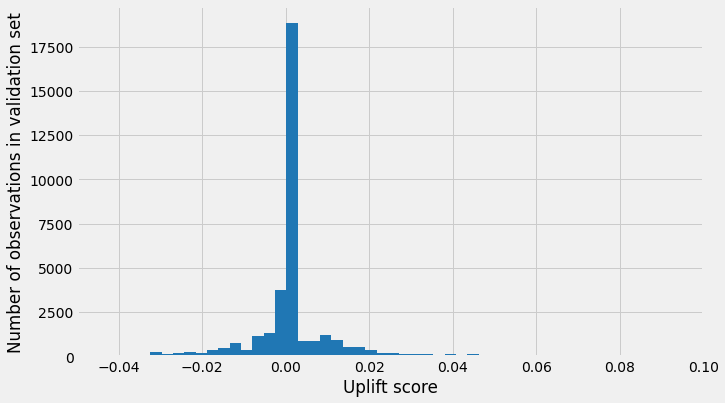

In [28]:
plt.figure(figsize = (10,6))
plt.xlim(-.05, .1)
plt.hist(result.uplift_score, bins=1000, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

## Qini Curve

In [29]:
def qini_rank(uplift): 
    # Function to Rank the data by the uplift score
    ranked = pd.DataFrame({'ranked uplift':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['ranked uplift'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='ranked uplift').reset_index(drop=True)
    return ranked

def qini_eval(ranked):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['ranked uplift'] * uplift_model['uplift'].iloc[-1],5)
    
    uplift_model['Number_of_exposed_customers'] = np.arange(len(uplift_model))+1
    uplift_model['visits_gained'] = uplift_model.uplift*len(uplift_model)
    
    # Add q0
    q0 = pd.DataFrame({'ranked uplift':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='ranked uplift').reset_index(drop = True)
    return merged, uplift_model

def uplift_curve(uplift_model):
    plt.figure(figsize = (10,6))
    # plot the data
    ax = uplift_model['visits_gained'].plot(color=['#2077B4'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Number of customers treated')
    plt.ylabel('Incremental visits')
    plt.grid(b=True, which='major')
    return ax

def qini_plot(merged:pd.DataFrame, uplift_model:pd.DataFrame):
    gain_x = uplift_model['ranked uplift']
    gain_y = uplift_model.uplift
    qini = auc(gain_x, gain_y)
    # plot the data
    plt.figure(figsize = (10,6))
    mpl.rcParams['font.size'] = 8
    qini = auc(gain_x, gain_y)

    ax = plt.plot(gain_x, gain_y, color= '#2077B4',
        label='Normalized Uplift Model, Qini Score: {}'.format(round(qini,2)))
    
    plt.plot([0, gain_x.max()], [0, gain_y.max()],
        '--', color='tab:orange',
        label='Random Treatment')
    plt.legend()
    plt.xlabel('Porportion Targeted')
    plt.ylabel('Uplift')
    plt.grid(b=True, which='major')

    return ax

def plot_uplift(result:pd.DataFrame):
    # Function to plot the uplift curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax1 = uplift_curve(uplift_model)
    
    return ax1

def plot_qini(result:pd.DataFrame):
    # Function to plot the qini curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax2 = qini_plot(merged, uplift_model)
    
    return ax2 

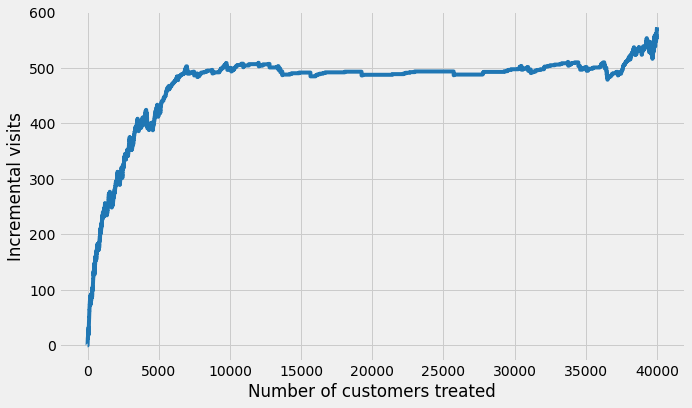

In [30]:
plot_uplift(result)

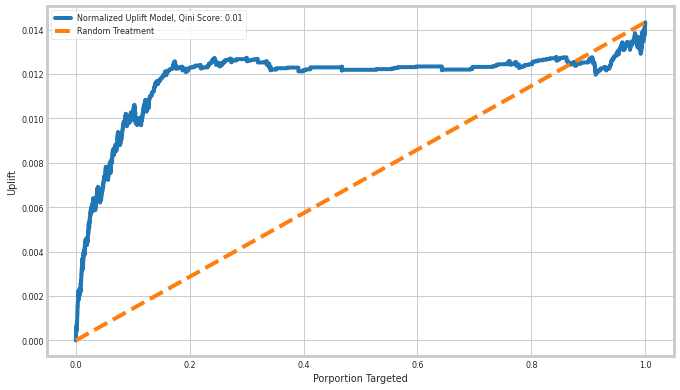

In [31]:
plot_qini(result)

# Models evalution

In [32]:
df = result.copy()

In [33]:
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'p_cn', 'p_cr', 'p_tn', 'p_tr', 'uplift_score',
       'target_class'],
      dtype='object')

In [34]:
df['old_target'] = (df['target_class'] % 2 == 0).apply(int)

feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10','f11']
target_col = 'old_target'
treatment_col = 'treatment'

In [35]:
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=13, test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class,old_target
12243338,25.725083,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.512845,0.001493,0.484003,0.001659,0.001027,2,1
7464379,25.976424,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.516118,0.001503,0.480710,0.001670,0.001117,2,1
12900257,12.616365,10.059654,9.041647,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0.487607,0.003301,0.505732,0.003360,-0.000249,2,1
1520567,26.000649,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.509062,0.001482,0.487808,0.001647,0.000924,2,1
5384778,22.377879,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.510021,0.001502,0.486767,0.001711,0.001133,2,1


## S-Learner

In [36]:
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

s_learner.fit(X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals


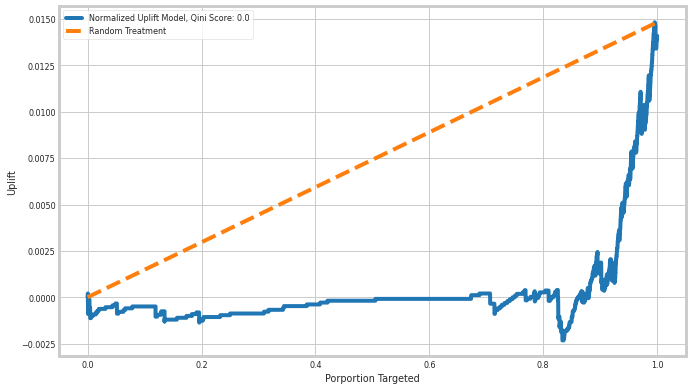

In [37]:
plot_qini(df_test)

### S-learner with Logistic Regression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


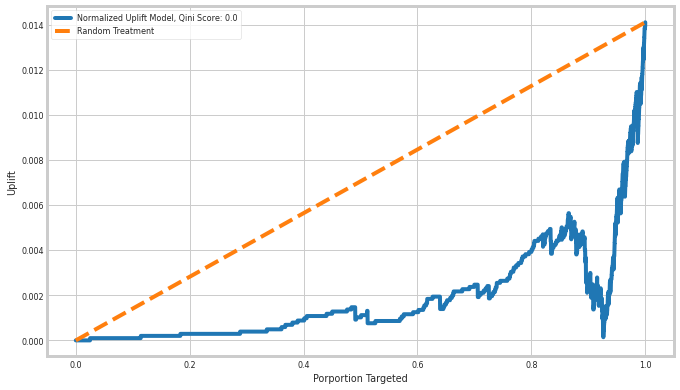

In [38]:
# Построим S-learner с логистической регрессией
from sklearn.linear_model import LogisticRegression

s_learner = BaseSClassifier(learner=LogisticRegression(verbose=0))
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

## T-Learner

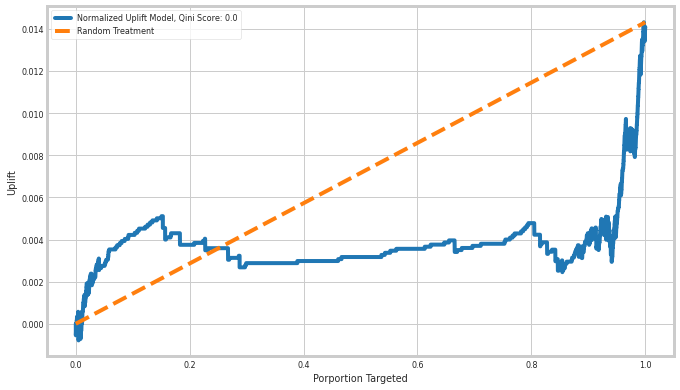

In [39]:

t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))


t_learner.fit(X=df_train[feature_cols],treatment=df_train[treatment_col],y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

### Tunned T-Learer model

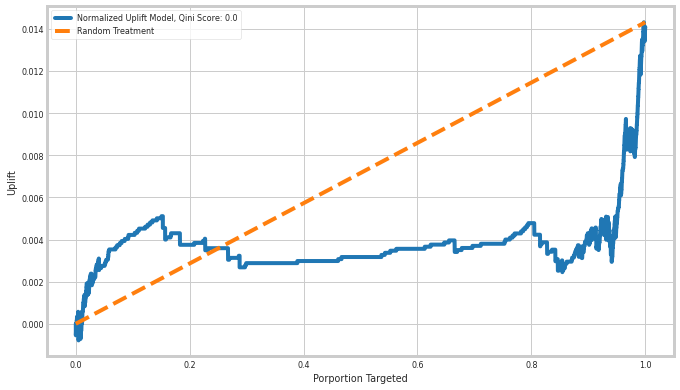

In [40]:
ctb_clf_tr = CatBoostClassifier(random_seed=13, verbose=0)
ctb_clf_ctrl = CatBoostClassifier(random_seed=13, verbose=0)


ctb_clf_tr.fit(df_train[df_train[treatment_col] == 1][feature_cols], df_train[df_train[treatment_col] == 1][target_col])
ctb_clf_ctrl.fit(df_train[df_train[treatment_col] == 0][feature_cols], df_train[df_train[treatment_col] == 0][target_col])

# Describe the method that calculates the uplift
def compute_t_uplift(ctb_clf_tr, ctb_clf_ctrl, X):
    X[treatment_col] = 1
    predict_treatment = ctb_clf_tr.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    
    X[treatment_col] = 0
    predict_control = ctb_clf_ctrl.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    
    uplift = predict_treatment - predict_control
    return uplift

# Evaluate uplift effects
df_test['uplift_score'] = compute_t_uplift(ctb_clf_tr, ctb_clf_ctrl, df_test)
plot_qini(df_test)

## X-learner Model

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

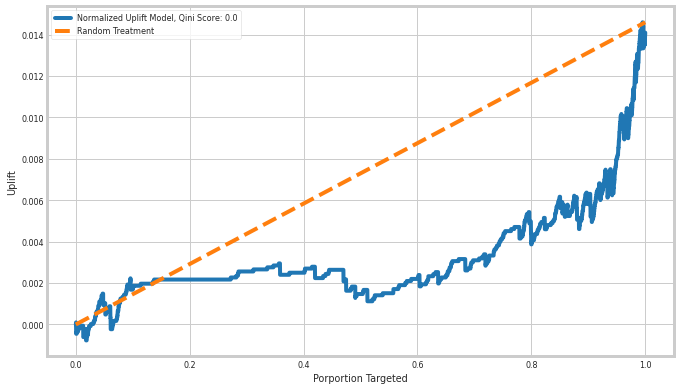

In [42]:
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=13),
                           effect_learner=LinearRegression())


x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

## R-learner Model

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

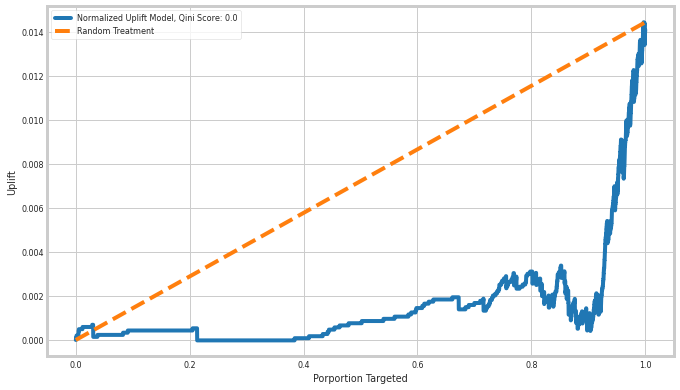

In [43]:
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(),
                            effect_learner=LinearRegression())


r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

## Uplift Tree Model

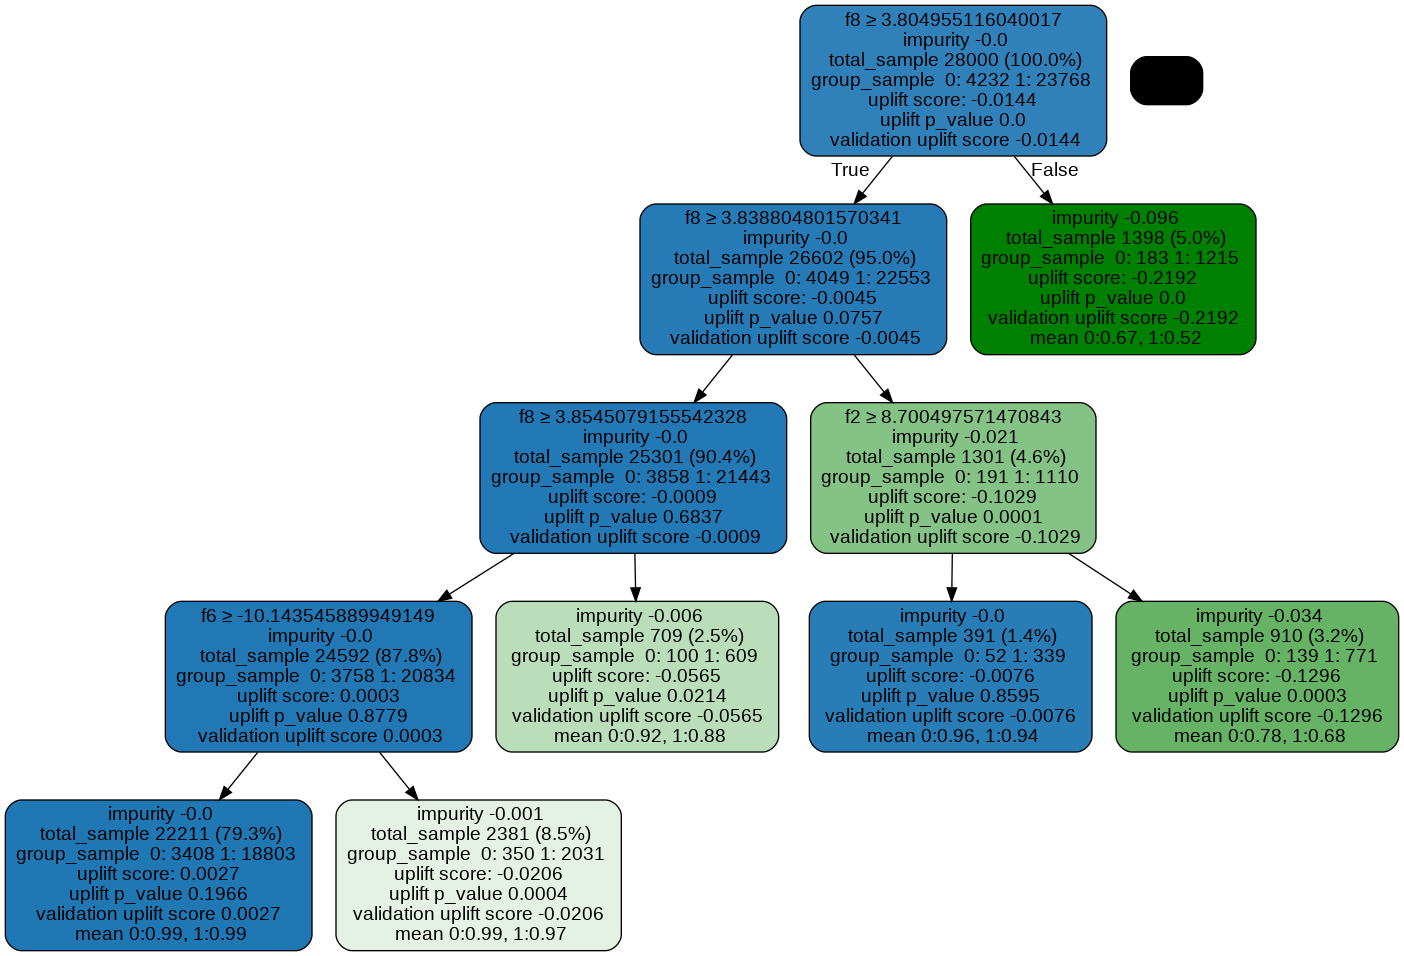

In [45]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


from IPython.display import Image

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_cols)
Image(graph.create_png())


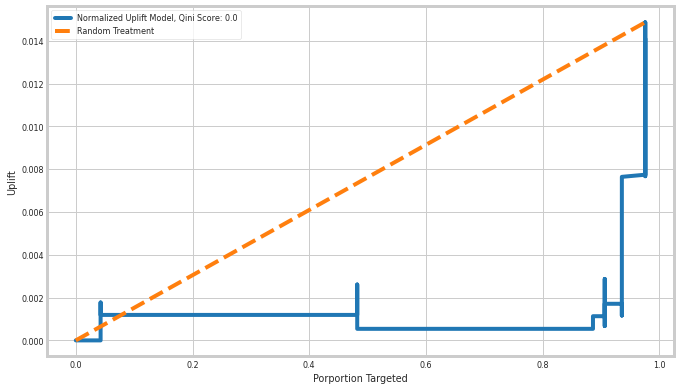

In [49]:
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

### Random Forest Model

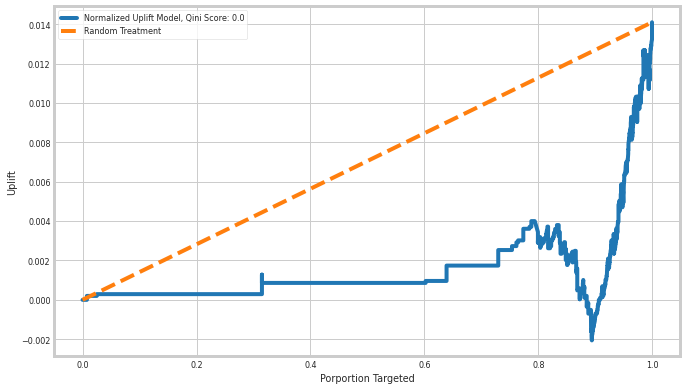

In [50]:
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals
plot_qini(df_test)

# Conclusion

In most models, the uplift shows negative values.
This means that communication with this group had a negative effect and the model found the type of clients who react negatively to communication - the type do not disturb.